# Importing the necessary packages

In [112]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , classification_report
from imblearn.over_sampling import SMOTE
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [113]:
mpl.rcParams['figure.figsize'] = (15, 18)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Read the data

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('day_approach_maskedID_timeseries.csv')
convert_dict = {'nr. sessions': int } #convert nr.sessions to int 
raw_df = raw_df.astype(convert_dict)
raw_df.head()

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4


In [4]:
# This section displays the percentage of the majority class
neg, pos = np.bincount(raw_df['injury'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 42766
    Positive: 583 (1.36% of total)



In [5]:
#Dropping the unnecessary columns/features
cleaned_df = raw_df.copy()
cleaned_df.pop('Date')
cleaned_df.pop('Athlete ID')

0         0
1         0
2         0
3         0
4         0
         ..
42761    71
42762    71
42763    71
42764    71
42765    71
Name: Athlete ID, Length: 42766, dtype: int64

In [6]:
X = cleaned_df.drop('injury', axis = 1)
y = cleaned_df['injury']

In [7]:
X.shape

(42766, 70)

# Applying Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
#This is because the data is so imbalanced. The minority class is oversampled with new similar data is generated to compensate its minimal numbers
smote_technique = SMOTE(sampling_strategy='minority')
X_smt, y_smt = smote_technique.fit_resample(X, y)

In [9]:
y_smt.value_counts() #class counts now match

0    42183
1    42183
Name: injury, dtype: int64

In [10]:
#Data is split to Train and test 
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.3, random_state=15, stratify=y_smt)


# Defining the Deep Nearal Network Model

In [11]:
dnn_model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(70,), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

2022-10-17 13:39:25.669507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
#Model compliation
dnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=METRICS)

In [14]:
dnn_model.fit(X_train_smt, y_train_smt, callbacks = [early_stopping], epochs=300)

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1846/1846 [==============================] - 10s 3ms/step - loss: 0.7267 - tp: 18362.0000 - fp: 14070.0000 - tn: 15458.0000 - fn: 11166.0000 - accuracy: 0.5727 - precision: 0.5662 - recall: 0.6219 - auc: 0.5950 - prc: 0.5489
Epoch 2/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.6065 - tp: 24601.0000 - fp: 14879.0000 - tn: 14649.0000 - fn: 4927.0000 - accuracy: 0.6646 - precision: 0.6231 - recall: 0.8331 - auc: 0.7050 - prc: 0.6507
Epoch 3/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.5711 - tp: 25203.0000 - fp: 13349.0000 - tn: 16179.0000 - fn: 4325.0000 - accuracy: 0.7007 - precision: 0.6537 - recall: 0.8535 - auc: 0.7

1846/1846 [==============================] - 5s 2ms/step - loss: 0.4318 - tp: 27439.0000 - fp: 9811.0000 - tn: 19717.0000 - fn: 2089.0000 - accuracy: 0.7985 - precision: 0.7366 - recall: 0.9293 - auc: 0.8494 - prc: 0.8080
Epoch 34/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4318 - tp: 27468.0000 - fp: 9799.0000 - tn: 19729.0000 - fn: 2060.0000 - accuracy: 0.7992 - precision: 0.7371 - recall: 0.9302 - auc: 0.8507 - prc: 0.8074
Epoch 35/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4293 - tp: 27476.0000 - fp: 9718.0000 - tn: 19810.0000 - fn: 2052.0000 - accuracy: 0.8007 - precision: 0.7387 - recall: 0.9305 - auc: 0.8514 - prc: 0.8071
Epoch 36/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4288 - tp: 27484.0000 - fp: 9637.0000 - tn: 19891.0000 - fn: 2044.0000 - accuracy: 0.8022 - precision: 0.7404 - recall: 0.9308 - auc: 0.8518 - prc: 0.8085
Epoch 37/300
1846/1846 [==============================] - 5s 3ms/step - l

1846/1846 [==============================] - 6s 3ms/step - loss: 0.4124 - tp: 27731.0000 - fp: 9333.0000 - tn: 20195.0000 - fn: 1797.0000 - accuracy: 0.8115 - precision: 0.7482 - recall: 0.9391 - auc: 0.8610 - prc: 0.8180
Epoch 68/300
1846/1846 [==============================] - 9s 5ms/step - loss: 0.4134 - tp: 27754.0000 - fp: 9399.0000 - tn: 20129.0000 - fn: 1774.0000 - accuracy: 0.8108 - precision: 0.7470 - recall: 0.9399 - auc: 0.8606 - prc: 0.8184
Epoch 69/300
1846/1846 [==============================] - 6s 3ms/step - loss: 0.4132 - tp: 27746.0000 - fp: 9423.0000 - tn: 20105.0000 - fn: 1782.0000 - accuracy: 0.8103 - precision: 0.7465 - recall: 0.9397 - auc: 0.8603 - prc: 0.8186
Epoch 70/300
1846/1846 [==============================] - 5s 3ms/step - loss: 0.4115 - tp: 27799.0000 - fp: 9367.0000 - tn: 20161.0000 - fn: 1729.0000 - accuracy: 0.8121 - precision: 0.7480 - recall: 0.9414 - auc: 0.8635 - prc: 0.8203
Epoch 71/300
1846/1846 [==============================] - 10s 5ms/step - 

In [15]:
#Using the trained model, the prediction is done on the test set
dnn_preds_smt = dnn_model.predict(X_test_smt)
dnn_preds_smt = np.round(dnn_preds_smt)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
791/791 [==============================] - 2s 2ms/step


In [16]:
#Display the classification report of the model out of prediction using the test data
print(classification_report(y_test_smt,dnn_preds_smt))


              precision    recall  f1-score   support

           0       0.93      0.84      0.88     12655
           1       0.86      0.93      0.89     12655

    accuracy                           0.89     25310
   macro avg       0.89      0.89      0.89     25310
weighted avg       0.89      0.89      0.89     25310



In [17]:
#function to display the confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  10683
Legitimate Transactions Incorrectly Detected (False Positives):  1972
Fraudulent Transactions Missed (False Negatives):  841
Fraudulent Transactions Detected (True Positives):  11814
Total Fraudulent Transactions:  12655


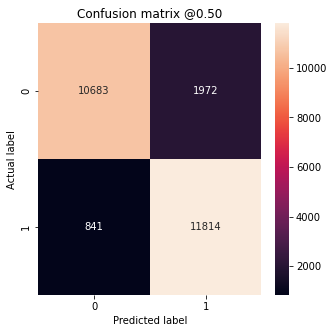

In [18]:
plot_cm(y_test_smt, dnn_preds_smt)

# Saving the trained Model

In [123]:
# Calling `save('my_model')` creates a SavedModel folder `dnn_model`.
dnn_model.save("dnn_model")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Sample prediction

In [121]:
def predict(model, record):
    k = np.array(record).reshape(1,70)
    prediction = int(np.round(dnn_model.predict(k))[0][0])
    return prediction

In [109]:
#Sample record to predict
k = np.array(X_test_smt.iloc[1]).reshape(1,70)

In [117]:
#Predict using the loaded saved model
reconstructed_model = keras.models.load_model("dnn_model")

In [122]:
predict(reconstructed_model,k)

1/1 [==============================] - 0s 69ms/step


1